In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pymc3 as pm
from collections import Counter
from scipy import stats
import seaborn as sns
import pandas as pd

## 1. Implementación del modelo Beta-Binomial para la moneda

#### Caso uniforme: B(1,1)
Para modelar el _prior_ $\theta$ utilizaremos en este caso, una distribución Beta con sus parámetros $\alpha$ y $\beta$ iguales a 1, lo que es equivalente a una distribución uniforme (Unif(0,1)). Por su parte para modelar $k$ utilizaremos una distribución binomial.
<br>
Se implementarán las distribuciones mencionadas para el experimento de arrojar una moneda al aire 6 veces y en todas ellas se obtuvo "cara".

In [3]:
model_uniform = pm.Model()
with model_uniform:
    theta = pm.Beta('theta_uniform', 1, 1)
    tiradas = pm.Binomial('tiradas', n=6, p=theta, observed=6)
    trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1213.50it/s]


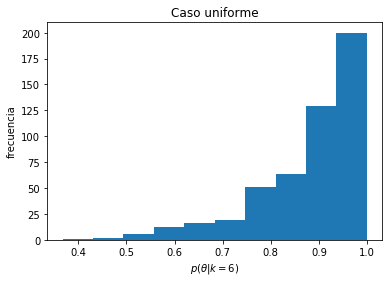

In [4]:
hist(trace.theta_uniform)
title('Caso uniforme')
xlabel(r'$p(\theta | k = 6)$')
ylabel('frecuencia')

A partir de un $\theta$ uniforme se obtuvo que el _posterior_ (p($\theta$|$k$)) indicaría que la moneda está cargada.

#### Caso Honesto: B(50,50)

En este caso el _prior_ se modelará teniendo en cuenta que la probabilidad de sacar "cara" o "ceca" al arrojar la moneda es 0.5 en ambos casos. Es decir, se asume una "moneda honesta".
<br>
Se implementará la distribución Beta con los parámetros correspondientes y nuevamente una distribución binomial para modelar _k_ en el experimento de arrojar una moneda al aire 6 veces y obtener "cara" en todos los casos.

In [33]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50) 
    tiradas = pm.Binomial('tiradas', n=6, p=theta_honest, observed=6)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1193.59it/s]


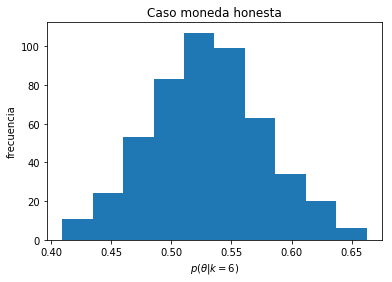

In [34]:
hist(trace.theta_honest)
title('Caso moneda honesta')
xlabel(r'$p(\theta|k = 6)$')
ylabel('frecuencia')

En este caso, a  diferencia del anterior, no se asume desde un primer momento que la moneda está cargada y eso mismo se ve reflejado en la probabilidad p($\theta$|$k$). 

In [6]:
#vemos si la distribucion se centra en 0.5
model_honest = pm.Model()
with model_honest:
    theta_honest_prior = pm.Beta('theta_honest', 50, 50) 
    trace_prior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1193.61it/s]


Si comparamos las distribución del prior de $\theta$ versus su posterior, vemos cómo la media se corre levemente obteniéndose una media de ~ 0.53 lo que reflejaría el resultado de las seis tiradas "cara".

In [9]:
print('Media de p(theta): {:.4f}'.format(trace_prior.theta_honest.mean()))
print('Media de p(theta | k = 6): {:.4f}'.format(trace.theta_honest.mean()))

Media de p(theta): 0.5002
Media de p(theta | k = 6): 0.5377


## 2. MAP y medias de las distribuciones

Para lograr una mejor descripción de las probabilidades encontradas en los dos casos de estudio, se calculan el Máximo A Posteriori y las medias.

#### Caso Uniforme

In [10]:
model_uniform = pm.Model()
with model_uniform:
    theta_uniform = pm.Beta('theta_uniform', 1, 1)
    tiradas = pm.Binomial('tiradas', p=theta_uniform, n=6, observed=6)
    trace = pm.sample()
    MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1160.09it/s]
logp = -0.0023631, ||grad|| = 0.0023627: 100%|██████████| 20/20 [00:00<00:00, 1128.11it/s] 


In [11]:
print('MAP Estimate para beta(1, 1): {}'.format(MAP['theta_uniform']))
print('Media para beta(1, 1): {}'.format(mean(trace.theta_uniform)))

MAP Estimate para beta(1, 1): 0.9999984620831801
Media para beta(1, 1): 0.8674473019027689


#### Caso Honesto

In [14]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)
    tiradas = pm.Binomial('tiradas', p=theta_honest, n=6, observed=6)
    trace = pm.sample()
    MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1159.66it/s]
logp = -2.0846, ||grad|| = 3: 100%|██████████| 6/6 [00:00<00:00, 1204.80it/s]


In [15]:
print('MAP Estimate para beta(50, 50): {}'.format(MAP['theta_honest']))
print('Media para beta(50, 50): {}'.format(mean(trace.theta_honest)))

MAP Estimate para beta(50, 50): 0.5288461537406147
Media para beta(50, 50): 0.5349805636981291


En el caso de prior uniforme, tanto el MAP como la media de la distribución a posteriori de $\theta$ se encuentran cerca del 1 (~0.999 y ~0.867 respectivamente), indicando que la moneda está cargada para que salga cara. En cambio, en el caso del prior que asume una moneda honesta, el MAP y la media de la distribución a posteriori siguen cerca de 0.5, aunque con un leve corrimiento hacia 1 lo que mostraría el sesgo (~0.528 y ~0.534 respectivamente).

## 3. Predicción

Aquí se querrá predecir el resultado de un próximo lanzamiento de moneda teniendo en cuenta la información ya modelada.

#### Caso uniforme

In [16]:
model_uniform = pm.Model()
with model_uniform:
    theta_uniform = pm.Beta('theta_uniform', 1, 1)
    dato = pm.Binomial('dato', p=theta_uniform, n=6, observed=6)
    post_uniform = pm.Binomial('post_uniform', p=theta_uniform, n=6)
    trace = pm.sample()

Assigned NUTS to theta_uniform_logodds__
Assigned Metropolis to post_uniform
 97%|█████████▋| 972/1000 [00:01<00:00, 620.73it/s]/home/march/anaconda2/envs/py3/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.892782335828, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:01<00:00, 616.92it/s]


In [17]:
count = Counter(sort(trace.post_uniform))

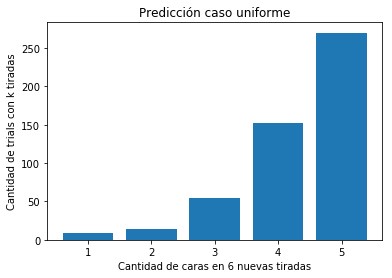

In [18]:
bar(arange(len(count)) + 1, count.values())
title('Predicción caso uniforme')
xlabel('Cantidad de caras en 6 nuevas tiradas')
ylabel('Cantidad de trials con k tiradas')

Teniendo en cuenta el _posterior_ de $\theta$ dado los datos se estima que la moneda está cargada, la predicción que se obtiene se ve completamente influenciada resultando mayor la probabilidad que vuelva a salir muchas caras en los próximos lanzamientos.

#### Caso honesto 

In [19]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)
    dato = pm.Binomial('dato', p=theta_honest, n=6, observed=6)
    post_honest = pm.Binomial('post_honest', p=theta_honest, n=6)
    trace = pm.sample()

Assigned NUTS to theta_honest_logodds__
Assigned Metropolis to post_honest
100%|██████████| 1000/1000 [00:01<00:00, 628.47it/s]


In [20]:
count = Counter(sort(trace.post_honest))

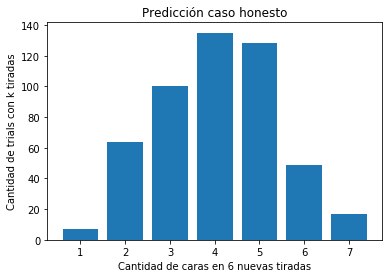

In [21]:
bar(arange(len(count)) + 1, count.values())
title('Predicción caso honesto')
xlabel('Cantidad de caras en 6 nuevas tiradas')
ylabel('Cantidad de trials con k tiradas')

Como era de esperarse, si en el _prior_ se asume una moneda honesta, en el _posterior_ se mantiene dicha hipótesis. De esta forma, la predicción para el resultado de los próximos lanzamientos menos influenciada que para el caso cargado.

## 4. Comparaciones entre datos

Con el objetivo de analizar cuánto influyen los datos iniciales y las creencias que son asumidas en el _prior_ se pondrán a prueba dos experimentos que se diferencian en la cantidad de tiradas y resultados obtenidos.

In [16]:
def uniforme_vs_honesto(cant_tiradas):
    model_uniform = pm.Model()
    with model_uniform:
        theta_uniform = pm.Beta('theta_uniform', 1, 1)
        tiradas = pm.Binomial('tiradas', p=theta_uniform, n=cant_tiradas, observed=cant_tiradas)
        #post_uniform = pm.Binomial('post_uniform', p=theta_uniform, n=cant_tiradas)
        trace_uniforme = pm.sample()
    MAP_uniforme = pm.find_MAP(model=model_uniform)

    model_honest = pm.Model()
    with model_honest:
        theta_honest = pm.Beta('theta_honest', 50, 50)
        tiradas = pm.Binomial('tiradas', p=theta_honest, n=cant_tiradas, observed=cant_tiradas)
        #post_honest = pm.Binomial('post_honest', p=theta_honest, n=cant_tiradas)
        trace_honesto = pm.sample()
    MAP_honesto = pm.find_MAP(model=model_honest)
        
    return trace_uniforme, MAP_uniforme, trace_honesto, MAP_honesto

In [17]:
trace_uniforme_20, MAP_uniforme_20, trace_honesto_20, MAP_honesto_20 = uniforme_vs_honesto(20)
trace_uniforme_3, MAP_uniforme_3, trace_honesto_3, MAP_honesto_3 = uniforme_vs_honesto(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 95%|█████████▌| 952/1000 [00:00<00:00, 1053.56it/s]/home/stella/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:00<00:00, 1058.31it/s]
logp = -7.0849e-06, ||grad|| = 7.6896e-06: 100%|██████████| 22/22 [00:00<00:00, 1370.71it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1095.18it/s]
logp = -11.789, ||grad|| = 10: 100%|██████████| 6/6 [00:00<00:00, 833.50it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:01<00:00, 913.16it/s]
logp = -0.0011816, ||grad|| = 0.0011814: 100%|██████████| 19/19 [00:00<00:00, 1734.09it/s]  
Auto-assigning NUTS sampler...
Initializ

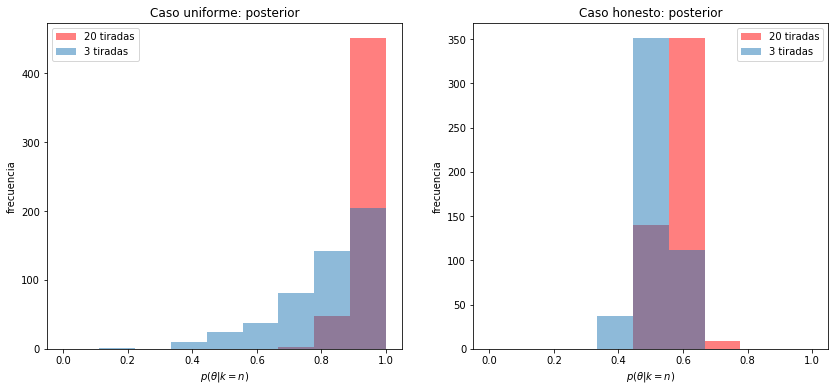

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plt.sca(axs[0])
bins = linspace(0, 1, 10)
hist_20 = hist(trace_uniforme_20.theta_uniform, label='20 tiradas', color='red', bins=bins, alpha=0.5)
hist_3 = hist(trace_uniforme_3.theta_uniform, label='3 tiradas', bins=bins, alpha=0.5)
legend()
title('Caso uniforme: posterior')
xlabel(r'$p(\theta | k = n)$')
ylabel('frecuencia')

plt.sca(axs[1])
bins = linspace(0, 1, 10)
hist_20 = hist(trace_honesto_20.theta_honest, label='20 tiradas', color='red', bins=bins, alpha=0.5)
hist_3 = hist(trace_honesto_3.theta_honest, label='3 tiradas', bins=bins, alpha=0.5)
legend()
title('Caso honesto: posterior')
xlabel(r'$p(\theta | k = n)$')
ylabel('frecuencia')

In [66]:
df_unif = pd.DataFrame({
        'MAP': {'3 tiradas': MAP_uniforme_3['theta_uniform'],
                '20 tiradas': MAP_uniforme_20['theta_uniform']},
        'mean': {'3 tiradas': trace_uniforme_3.theta_uniform.mean(),
                 '20 tiradas': trace_uniforme_20.theta_uniform.mean()}
    })
df_unif.T

,20 tiradas,3 tiradas
MAP,0.9999996155210419,0.999996924163579
mean,0.960925,0.803104


In [73]:
df_honesto = pd.DataFrame({
        'MAP': {'3 tiradas': MAP_honesto_3['theta_honest'],
                '20 tiradas': MAP_honesto_20['theta_honest']},
        'mean': {'3 tiradas': trace_honesto_3.theta_honest.mean(),
                 '20 tiradas': trace_honesto_20.theta_honest.mean()}
    })
df_honesto.T

,20 tiradas,3 tiradas
MAP,0.5847457607428355,0.5148514851428415
mean,0.579507,0.516895


En primer lugar, comparando los experimentos según su número de tiradas, el caso de 20 tiradas "cara" aporta más evidencia a la moneda cargada (caso uniforme, histogramas panel izquierdo). En este gráfico se observa cómo se duplica la frecuencia a la hora de obtener un resultado "cara" con probabilidad ~1 para las 20 tiradas en comparación de 3 tiradas. Siguiendo en el caso del prior uniforme, comparando la moda y media en cada experimento, se registra que, si bien los valores de MAP recién difieren en su sexta cifra significativa, la media presenta una diferencia de ~16%.

Por su parte, para el caso honesto, en el histograma del panel derecho se observa un corrimiento hacia la derecha: la distribución de 20 tiradas está centrada en 0.6 mientras que la de 3 tiradas en 0.5. A su vez, las diferencias registradas en la moda y media entre un experimento y otro no superan los 0.07 puntos centrándose en 0.549.

## 5. Experiencia previa

Por último se quiere modelar, según la experiencia propia, a partir de cuántos lanzamientos con igual resultado se considera que una moneda está cargada.

In [20]:
def dist_rel(alpha_prior, observed=25):
    model_previa = pm.Model()
    with model_previa:
        theta = pm.Beta('theta', alpha_prior, alpha_prior)
        tiradas = pm.Binomial('tiradas', p=theta, n=observed, observed=observed)
        trace = pm.sample(model=model_previa, progressbar=False)
        
    posterior_mean = trace.theta.mean()
    prior_mean = 0.5
    prior_std = stats.beta.std(a=alpha_prior, b=alpha_prior)
    return abs(posterior_mean - prior_mean) / prior_std

In [21]:
xs = np.linspace(1, 50, 30)
ys = np.array([dist_rel(a) for a in xs])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/stella/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.881106473838, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/s

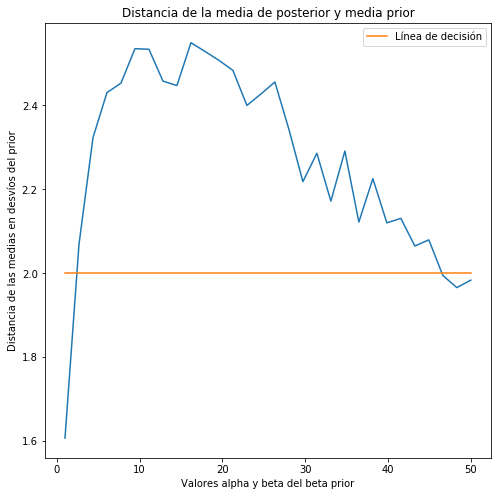

In [22]:
figure(figsize=(8, 8))
plot(xs, ys)
plot([1, 50], [2, 2], label='Línea de decisión')
title('Distancia de la media de posterior y media prior')
xlabel('Valores alpha y beta del beta prior')
ylabel('Distancia de las medias en desvíos del prior')
legend()

Usamos como criterio para considerar que una moneda está cargada luego de $n$ tiradas si la media del _posterior_ de $\theta$ se diferencia en $k$ desvíos standard de la media del _prior_. Nuestra intuición es que consideraríamos una moneda cargada a partir de 25 tiradas donde todas son caras. El gráfico muestra cómo se distancia la media del _posterior_ de la media del _prior_ en desvíos standard para distintos _priors_ del valor $\theta$. 

Hacia la izquierda del gráfico tenemos como _prior_ $\beta(1, 1)$. En ese caso, consideramos todos los posibles valores de $\theta$ muy probables. Hacia la derecha del gráfico tenemos como _prior_ $\beta(50, 50)$. En este caso consideramos que la moneda es honesta, por lo tanto es necesario observar muchas más tiradas "cara" para abandonar esta hipótesis.

En el gráfico se observa cómo la distancia entre la media del _posterior_ y la media del _prior_ crece mucho más pronunciadamente con parámetros de Beta pequeños (1 a 9), se mantiene en niveles altos (~2.4 desvíos standard de diferencia) hasta $\beta(25,25)$ y luego comienza a bajar. Esto indicaría cómo el hecho que a medida que se asume (en el _prior_) con más "convicción"  que la moneda es honesta (es decir, aumentando los parámetros y fijando el número de tiradas) se refleja en el resultado del lanzamiento (_posterior_) achicándose el número de desvíos standard de diferencia.
